## 0 Load modules

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gsw
import pandas as pd
import cftime
import nc_time_axis
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

## 1 Load NEMO data
### 1.1 load NEMO salinity profiles

In [6]:
ds_NEMO=xr.open_mfdataset('Profile_plot/eORCA025.L121-OPM026_y????m??_mean_profileS.nc').squeeze(dim=['x','y']).interp(deptht=range(0,2000,5))
year=(ds_NEMO.time_centered.dt.month/12+ds_NEMO.time_centered.dt.year).astype(int)
da_sNEMO_PIG=xr.DataArray(ds_NEMO.mean_vosaline_mask_PIG.values[:,:], coords={'time':year.values[:],"depth":-ds_NEMO.deptht.values[:]}, dims=["time","depth"])
da_sNEMO_DOT=xr.DataArray(ds_NEMO.mean_vosaline_mask_DOTSON.values[:,:], coords={'time':year.values[:],"depth":-ds_NEMO.deptht.values[:]}, dims=["time","depth"])

### 1.2 load NEMO temperature profiles

In [7]:
ds_NEMO=xr.open_mfdataset('Profile_plot/eORCA025.L121-OPM026_y????m??_mean_profileT.nc').squeeze(dim=['x','y']).interp(deptht=range(0,2000,5))
da_tNEMO_PIG=xr.DataArray(ds_NEMO.mean_votemper_mask_PIG.values[:,:], coords={'time':year.values[:],"depth":-ds_NEMO.deptht.values[:]}, dims=["time","depth"])
da_tNEMO_DOT=xr.DataArray(ds_NEMO.mean_votemper_mask_DOTSON.values[:,:], coords={'time':year.values[:],"depth":-ds_NEMO.deptht.values[:]}, dims=["time","depth"])

### 1.3 Load NEMO ice shelf melt

In [8]:
ds_isf_mod=xr.open_dataset('DATA/ISF_ALL_eORCA025.L121-OPM026_1y.nc')
ds_isf_mod['isfmelt_DOTS']=ds_isf_mod['isfmelt_DOTS']*-1
ds_isf_mod['isfmelt_PINE']=ds_isf_mod['isfmelt_PINE']*-1
time_mod=[datetime.strptime(str(time),'%Y-%m-%d %H:%M:%S').year for time in ds_isf_mod.time_centered.values]

### 1.4 Get depth of NEMO outputs

In [9]:
zNEMO=-ds_NEMO.deptht.values

### 1.5 Function to process NEMO data

In [10]:
def NEMO_data(da_smod,da_tmod,z):
    smod=da_smod.groupby('time').mean('time')
    tmod=da_tmod.groupby('time').mean('time')
    smod_mean=smod.sel(time=np.arange(1995,2019)).mean('time')
    tmod_mean=tmod.sel(time=np.arange(1995,2019)).mean('time')

    smodmin=np.zeros(shape=smod_mean.shape)
    smodmax=np.zeros(shape=smod_mean.shape)
    tmodmin=np.zeros(shape=tmod_mean.shape)
    tmodmax=np.zeros(shape=tmod_mean.shape)
    for ik in range(0,smod.shape[1]):
        smodmin[ik]=np.nanmin(smod.sel(time=np.arange(1995,2019))[:,ik])
        smodmax[ik]=np.nanmax(smod.sel(time=np.arange(1995,2019))[:,ik])
        tmodmin[ik]=np.nanmin(tmod.sel(time=np.arange(1995,2019))[:,ik])
        tmodmax[ik]=np.nanmax(tmod.sel(time=np.arange(1995,2019))[:,ik])

    ik=np.where(z[:]==-800)[0]
    print(ik)
    ts_smod_800=smod[:,ik]
    ts_tmod_800=tmod[:,ik]

    ik=np.where(z[:]==-400)[0]
    print(ik)
    ts_smod_400=smod[:,ik]
    ts_tmod_400=tmod[:,ik]

    ik=np.where(z[:]==-150)[0]
    print(ik)
    ts_smod_150=smod[:,ik]
    ts_tmod_150=tmod[:,ik]

    return smod_mean,tmod_mean,smodmin,smodmax,tmodmin,tmodmax,ts_smod_800,ts_smod_400,ts_smod_150,ts_tmod_800,ts_tmod_400,ts_tmod_150

## 2 Prepare observational dataset
### 2.1 Process Dotson ice shelf ocean profile observations

In [13]:
# Dotson
ds_DOTSON=xr.open_dataset('Profile_plot/DotsonCTDsLADCP_2000_2016.nc')
lon_dot_mesh,z_dot_mesh=np.meshgrid(ds_DOTSON.Lon.values,ds_DOTSON.P.values)
lat_dot_mesh,_         =np.meshgrid(ds_DOTSON.Lat.values, ds_DOTSON.P.values)
ds_DOTSON.T.values=gsw.CT_from_pt(ds_DOTSON.S.values, ds_DOTSON.T.values)
ds_DOTSON.S.values=gsw.SA_from_SP(ds_DOTSON.S.values, z_dot_mesh, lon_dot_mesh, lat_dot_mesh)

da_sobs=xr.DataArray(ds_DOTSON.S.values[:,:], coords={'time':ds_DOTSON.Time.values[:],"depth":ds_DOTSON.P.values[:]}, dims=["depth","time"])
da_tobs=xr.DataArray(ds_DOTSON.T.values[:,:], coords={'time':ds_DOTSON.Time.values[:],"depth":ds_DOTSON.P.values[:]}, dims=["depth","time"])
sobs_DOTSON=da_sobs.groupby('time').mean('time')
tobs_DOTSON=da_tobs.groupby('time').mean('time')
sobs_DOTSON_mean=sobs_DOTSON.mean(axis=1)
tobs_DOTSON_mean=tobs_DOTSON.mean(axis=1)

z_DOTSON=-ds_DOTSON.P

sobs_DOTSON_min=np.zeros(shape=sobs_DOTSON_mean.shape)
sobs_DOTSON_max=np.zeros(shape=sobs_DOTSON_mean.shape)
tobs_DOTSON_min=np.zeros(shape=tobs_DOTSON_mean.shape)
tobs_DOTSON_max=np.zeros(shape=tobs_DOTSON_mean.shape)
for ik in range(0,sobs_DOTSON.shape[0]):
    sobs_DOTSON_min[ik]=np.nanmin(sobs_DOTSON[ik,:])
    sobs_DOTSON_max[ik]=np.nanmax(sobs_DOTSON[ik,:])
    tobs_DOTSON_min[ik]=np.nanmin(tobs_DOTSON[ik,:])
    tobs_DOTSON_max[ik]=np.nanmax(tobs_DOTSON[ik,:])

ik=np.where(z_DOTSON.values[:]==-800)[0]
print(ik)
ts_DOTSON_sobs_800=sobs_DOTSON[ik,:]
ts_DOTSON_tobs_800=tobs_DOTSON[ik,:]

ik=np.where(z_DOTSON.values[:]==-400)[0]
print(ik)
ts_DOTSON_sobs_400=sobs_DOTSON[ik,:]
ts_DOTSON_tobs_400=tobs_DOTSON[ik,:]


[799]
[399]


/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/495413235.py:22: RuntimeWarning: All-NaN axis encountered
  sobs_DOTSON_min[ik]=np.nanmin(sobs_DOTSON[ik,:])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/495413235.py:23: RuntimeWarning: All-NaN axis encountered
  sobs_DOTSON_max[ik]=np.nanmax(sobs_DOTSON[ik,:])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/495413235.py:24: RuntimeWarning: All-NaN axis encountered
  tobs_DOTSON_min[ik]=np.nanmin(tobs_DOTSON[ik,:])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/495413235.py:25: RuntimeWarning: All-NaN axis encountered
  tobs_DOTSON_max[ik]=np.nanmax(tobs_DOTSON[ik,:])


### 2.2 Process PIG ice shelf ocean profile observations

In [14]:
ds_PIG=xr.open_dataset('Profile_plot/T_S_profiles_dutrieux2014_PIGL.nc').squeeze(drop=True)
lon_pig=np.zeros(shape=ds_PIG.theta_ocean.values.shape[0])-100 # approximation for convertion
lat_pig=np.zeros(shape=ds_PIG.salinity_ocean.values.shape[0])-75 # approximation for convertion
z_pig_mesh,lon_pig_mesh=np.meshgrid(ds_PIG.depth.values,lon_pig)
_         ,lat_pig_mesh=np.meshgrid(ds_PIG.depth.values,lat_pig)
ds_PIG.theta_ocean.values   =gsw.CT_from_pt(ds_PIG.salinity_ocean.values, ds_PIG.theta_ocean.values)
ds_PIG.salinity_ocean.values=gsw.SA_from_SP(ds_PIG.salinity_ocean.values, z_pig_mesh, lon_pig_mesh, lat_pig_mesh)

da_sobs=xr.DataArray(ds_PIG.salinity_ocean.values[:,:], coords={'time':ds_PIG.time.values[:],"depth":ds_PIG.depth.values[:]}, dims=["time","depth"])
da_tobs=xr.DataArray(ds_PIG.theta_ocean.values[:,:], coords={'time':ds_PIG.time.values[:],"depth":ds_PIG.depth.values[:]}, dims=["time","depth"])
sobs_PIG=da_sobs
tobs_PIG=da_tobs
sobs_PIG_mean=sobs_PIG.mean(axis=0)
tobs_PIG_mean=tobs_PIG.mean(axis=0)

z_PIG=-ds_PIG.depth

sobs_PIG_min=np.zeros(shape=sobs_PIG_mean.shape)
sobs_PIG_max=np.zeros(shape=sobs_PIG_mean.shape)
tobs_PIG_min=np.zeros(shape=tobs_PIG_mean.shape)
tobs_PIG_max=np.zeros(shape=tobs_PIG_mean.shape)
for ik in range(0,sobs_PIG.shape[1]):
    sobs_PIG_min[ik]=np.nanmin(sobs_PIG[:,ik])
    sobs_PIG_max[ik]=np.nanmax(sobs_PIG[:,ik])
    tobs_PIG_min[ik]=np.nanmin(tobs_PIG[:,ik])
    tobs_PIG_max[ik]=np.nanmax(tobs_PIG[:,ik])

ik=np.where(z_PIG.values[:]==-800)[0]
print(ik)
ts_PIG_sobs_800=sobs_PIG[:,ik]
ts_PIG_tobs_800=tobs_PIG[:,ik]

ik=np.where(z_PIG.values[:]==-400)[0]
print(ik)
ts_PIG_sobs_400=sobs_PIG[:,ik]
ts_PIG_tobs_400=tobs_PIG[:,ik]

[79]
[39]


/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3810158017.py:23: RuntimeWarning: All-NaN axis encountered
  sobs_PIG_min[ik]=np.nanmin(sobs_PIG[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3810158017.py:24: RuntimeWarning: All-NaN axis encountered
  sobs_PIG_max[ik]=np.nanmax(sobs_PIG[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3810158017.py:25: RuntimeWarning: All-NaN axis encountered
  tobs_PIG_min[ik]=np.nanmin(tobs_PIG[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3810158017.py:26: RuntimeWarning: All-NaN axis encountered
  tobs_PIG_max[ik]=np.nanmax(tobs_PIG[:,ik])


### 2.3 Prepare ice shelf melt observations

In [15]:
Dico_PineIsland = {"year": [1994, 2007, 2009, 2010, 2012], "melt_Dutrieux":[45.2, 98.7, 73.0, 63.7, 31.9], "error_Dutrieux":[4.5, 9.9, 7.3, 6.4, 3.2]}
Dico_Getz = {"year": [2000, 2007], "melt_Jacobs":[41.9, 115.4], "error_Jacobs":[9.7, 6.4]}
Dico_Dotson = {"year": [2000, 2006, 2007, 2009, 2011, 2012, 2014, 2016], "melt_Jenkins":[25.0, 55.7, 44.4, 91.6, 53.8, 20.3, 20.9, 19.5], "error_Jenkins":[9.1, 15.3, 35.2, 31.6, 12.3, 6.1, 8.0, 15.4]}
Data_melting_PineIsland = pd.DataFrame(Dico_PineIsland)
Data_melting_Getz = pd.DataFrame(Dico_Getz)
Data_melting_Dotson= pd.DataFrame(Dico_Dotson)

dates = [year for year in Dico_Dotson['year']]
DOTS=xr.DataArray(Dico_Dotson['melt_Jenkins'],coords=[dates], dims=['time'],name='melt_Jenkins')

dates = [year for year in Dico_PineIsland['year']]
PINE=xr.DataArray(Dico_PineIsland['melt_Dutrieux'],coords=[dates], dims=['time'],name='melt_Jenkins')

## 3 Plot figure

/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:12: RuntimeWarning: All-NaN axis encountered
  smodmin[ik]=np.nanmin(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:13: RuntimeWarning: All-NaN axis encountered
  smodmax[ik]=np.nanmax(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:14: RuntimeWarning: All-NaN axis encountered
  tmodmin[ik]=np.nanmin(tmod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:15: RuntimeWarning: All-NaN axis encountered
  tmodmax[ik]=np.nanmax(tmod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:12: RuntimeWarning: All-NaN axis encountered
  smodmin[ik]=np.nanmin(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000g

[160]
[80]
[30]


/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:12: RuntimeWarning: All-NaN axis encountered
  smodmin[ik]=np.nanmin(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:13: RuntimeWarning: All-NaN axis encountered
  smodmax[ik]=np.nanmax(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:14: RuntimeWarning: All-NaN axis encountered
  tmodmin[ik]=np.nanmin(tmod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:15: RuntimeWarning: All-NaN axis encountered
  tmodmax[ik]=np.nanmax(tmod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000gn/T/ipykernel_12434/3707341482.py:12: RuntimeWarning: All-NaN axis encountered
  smodmin[ik]=np.nanmin(smod.sel(time=np.arange(1995,2019))[:,ik])
/var/folders/fj/r0q0fhhx4450585wlhdlw_s80000g

[160]
[80]
[30]


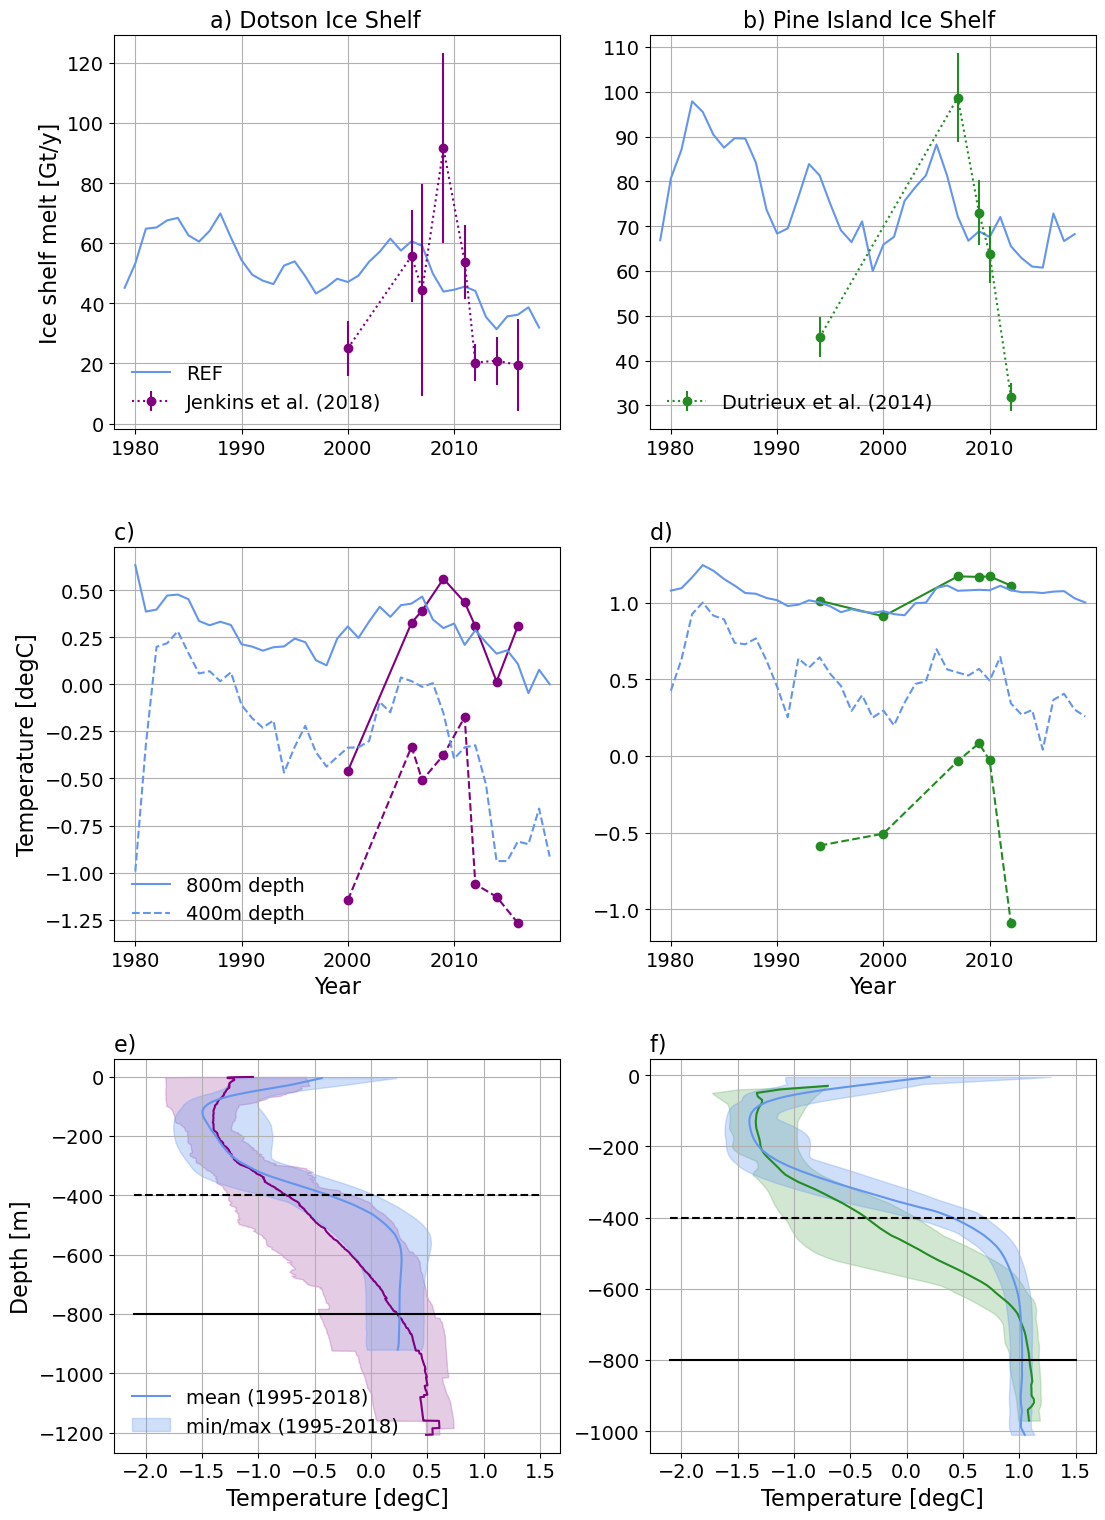

In [16]:
fig=plt.figure(figsize=np.array([290,400]) / 25.4)
gs = fig.add_gridspec(3, 2)
ax=[None]*6

########################################################################################
# Dotson melt
ax[0] = fig.add_subplot(gs[0,0])

plt.plot(time_mod,ds_isf_mod['isfmelt_DOTS'].values.squeeze(),label='REF',color='cornflowerblue')
plt.errorbar(DOTS.time,DOTS,yerr=Dico_Dotson['error_Jenkins'],marker='o',color='purple',linestyle=':',label='Jenkins et al. (2018)')

plt.title('{:25}'.format('a) Dotson Ice Shelf'),fontsize=16)
plt.ylabel('Ice shelf melt [Gt/y]',fontsize=16)
plt.xlim([1978,2020])
plt.xticks([1980,1990,2000,2010],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.grid()

# Pine island melt 
ax[1] = fig.add_subplot(gs[0,1])

plt.plot(time_mod,ds_isf_mod['isfmelt_PINE'].values.squeeze(),color='cornflowerblue')
plt.errorbar(PINE.time,PINE,yerr=Dico_PineIsland['error_Dutrieux'],marker='o',color='forestgreen',linestyle=':',label='Dutrieux et al. (2014)')

plt.title('{:25}'.format('b) Pine Island Ice Shelf'),fontsize=16)
plt.ylabel('')
plt.grid('on')
plt.xlim([1978,2020])
plt.xticks([1980,1990,2000,2010],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower left',frameon=False,fontsize=14)

########################################################################################
# Dotson ocean interannual variability

ax[2] = fig.add_subplot(gs[2,0])

smod_mean,tmod_mean,smodmin,smodmax,tmodmin,tmodmax,ts_smod_800,ts_smod_400,ts_smod_150,ts_tmod_800,ts_tmod_400,ts_tmod_150=NEMO_data(da_sNEMO_DOT,da_tNEMO_DOT,zNEMO)

plt.plot(tobs_DOTSON_mean,z_DOTSON,color='purple')
plt.fill_betweenx(z_DOTSON,tobs_DOTSON_min, tobs_DOTSON_max,color='purple',alpha=0.2)
plt.plot(tmod_mean,zNEMO,color='cornflowerblue',label='mean (1995-2018)')
plt.fill_betweenx(zNEMO,tmodmin, tmodmax,color='cornflowerblue',alpha=0.3,label='min/max (1995-2018)')
plt.plot([-2.1,1.5],[-400,-400],'--k')
plt.plot([-2.1,1.5],[-800,-800],'-k')

plt.title('{:25}'.format('e)'), loc='left', fontsize=16)
plt.grid('on')
plt.xlabel('Temperature [degC]',fontsize=16)
plt.ylabel('Depth [m]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower left',frameon=False,fontsize=14)

# Pine island ocean variability
ax[3] = fig.add_subplot(gs[1,0])

plt.plot(tobs_DOTSON.time,ts_DOTSON_tobs_800[0,:],'-o',color='purple')
plt.plot(tobs_DOTSON.time,ts_DOTSON_tobs_400[0,:],'--o',color='purple')

plt.plot(ts_tmod_800.time,ts_tmod_800[:],'-' ,color='cornflowerblue',label='800m depth')
plt.plot(ts_tmod_400.time,ts_tmod_400[:],'--',color='cornflowerblue',label='400m depth')

plt.title('{:25}'.format('c)'), loc='left', fontsize=16)
plt.grid()
plt.xlabel('Year',fontsize=16)
plt.ylabel('Temperature [degC]',fontsize=16)
plt.grid('on')
plt.xlim([1978,2020])
plt.xticks([1980,1990,2000,2010],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower left',frameon=False,fontsize=14)

########################################################################################
# Dotson mean profile

ax[4] = fig.add_subplot(gs[2,1])

smod_mean,tmod_mean,smodmin,smodmax,tmodmin,tmodmax,ts_smod_800,ts_smod_400,ts_smod_150,ts_tmod_800,ts_tmod_400,ts_tmod_150=NEMO_data(da_sNEMO_PIG,da_tNEMO_PIG,zNEMO)

plt.plot(tobs_PIG_mean,z_PIG,color='forestgreen')
plt.fill_betweenx(z_PIG,tobs_PIG_min, tobs_PIG_max,color='forestgreen',alpha=0.2)
plt.plot(tmod_mean,zNEMO,color='cornflowerblue') 
plt.fill_betweenx(zNEMO,tmodmin, tmodmax,color='cornflowerblue',alpha=0.3)
plt.plot([-2.1,1.5],[-400,-400],'--k')
plt.plot([-2.1,1.5],[-800,-800],'-k')

plt.grid('on')
plt.xlabel('Temperature [degC]',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('{:25}'.format('f)'), loc='left', fontsize=16)

# Pine Island mean profile
ax[5] = fig.add_subplot(gs[1,1])

plt.plot(tobs_PIG.time,ts_PIG_tobs_800[:,0],'-o',color='forestgreen')
plt.plot(tobs_PIG.time,ts_PIG_tobs_400[:,0],'--o',color='forestgreen')

plt.plot(ts_tmod_800.time,ts_tmod_800[:],'-' ,color='cornflowerblue',label='800m depth')
plt.plot(ts_tmod_400.time,ts_tmod_400[:],'--',color='cornflowerblue',label='400m depth')

plt.grid()
plt.xlabel('Year',fontsize=16)
plt.grid('on')
plt.xlim([1978,2020])
plt.xticks([1980,1990,2000,2010],fontsize=14)
plt.yticks(fontsize=14)
plt.title('{:25}'.format('d)'), loc='left', fontsize=16)

########################################################################################
# Adjust white space and save figure
plt.subplots_adjust(left=0.12, right=0.98 , bottom=0.05, top=0.95, hspace=0.3, wspace=0.2)

fig.savefig('fig06.png', format='png', dpi=150)